In [21]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import task_generation, learning
import tqdm

# choose a subset of tasks to learn
task_list = ['PRO_D', 'PRO_M', 'ANTI_D', 'ANTI_M']
# task_list = ['PRO_D']
n_trials = 40
nx = 4
sigma = 0.1
p_stay = 0.95
min_Te = 50
x_oracle = False

np.random.seed(0)

trials, epoch_list = task_generation.generate_trials(
    task_list, n_trials, nx, sigma, p_stay, min_Te, trial_order='blocked')

nc = len(task_list)
nz = len(epoch_list)

true_M, true_W, true_p0_z = task_generation.get_ground_truth(
    task_list, epoch_list, p_stay=p_stay, nx=nx)

num_epochs_each_task = [len(np.unique(task_generation.task_dict[task_type].\
                                      split('->'))) for task_type in task_list]
w_fixate = task_generation.make_delay_or_fixation_epoch(None, 1, 0, 0, d_stim=np.pi/2)
w_fixate = np.concatenate([w_fixate['s'], w_fixate['y']], axis=1)

LL_over_trials_across_time = np.zeros((n_trials, n_trials))

task_model = learning.TaskModel(
    nc=nc, nz=nz, nx=nx, sigma=sigma, d=w_fixate.shape[-1],
    n_epochs_each_task=num_epochs_each_task,
    w_fixate=w_fixate)

for itrial, trial in enumerate(trials):
    task_model.dynamic_initialize_W(trial)
    task_model.learn_single_trial(trial)
    LLs = []
    for _trial in trials:
        _, LL = task_model.get_stats(_trial)
        LLs.append(LL)
    LL_over_trials_across_time[itrial] = np.array(LLs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'Log likelihood per trial')

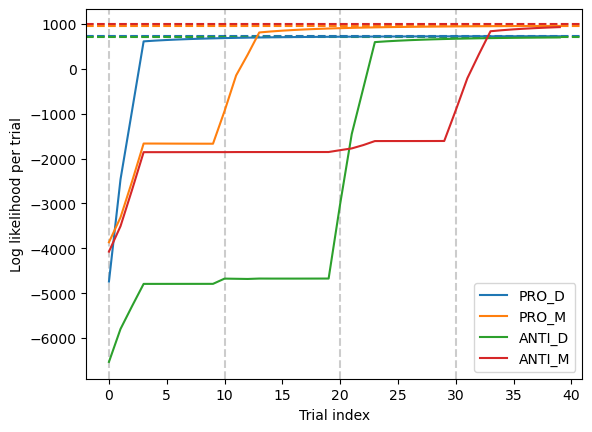

In [22]:
plt.figure()
n_trials_per_task = n_trials // nc

LL_over_trials_across_time_true_params = np.zeros((n_trials))
for itrial, trial in enumerate(trials):
    gamma, _, _, LL = learning.get_stats_for_single_trial(
        single_trial=trial,
        W=true_W,
        M=true_M,
        p0_z=true_p0_z,
        x_oracle=False,
        sigma=sigma)
    LL_over_trials_across_time_true_params[itrial] = LL
    
avg_LL_each_task_true_params = LL_over_trials_across_time_true_params.reshape(nc, -1).mean(1)
for i in range(nc):
    plt.axvline(n_trials_per_task * i, color='k', ls='--', alpha=0.2)
    trials_this_task = LL_over_trials_across_time.reshape(n_trials, nc, -1)[:, i, :]
    _ = plt.errorbar(range(n_trials), trials_this_task.mean(-1), color=f'C{i}', label=task_list[i])
    plt.axhline(avg_LL_each_task_true_params[i], color=f'C{i}', ls='--')
plt.legend()
# plt.ylim(0, 1200)
plt.xlabel('Trial index')
plt.ylabel('Log likelihood per trial')

In [27]:
w_fixate

array([[0., 0., 1., 0., 0., 1.]])

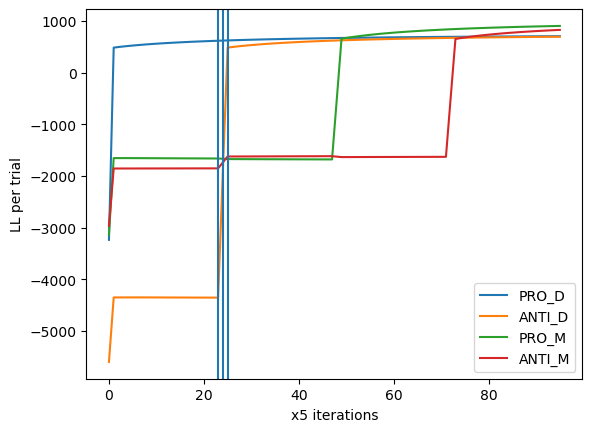

In [71]:
LL_diff_task = np.array(LL_across_trials_over_time)
LL_diff_task = LL_diff_task.reshape((LL_diff_task.shape[0], nc, -1)).mean(-1)

plt.figure()
plt.plot(LL_diff_task, label=task_list)
plt.legend()
plt.ylabel('LL per trial')
plt.xlabel('x5 iterations')
plt.axvline(23)
plt.axvline(24)
plt.axvline(25)


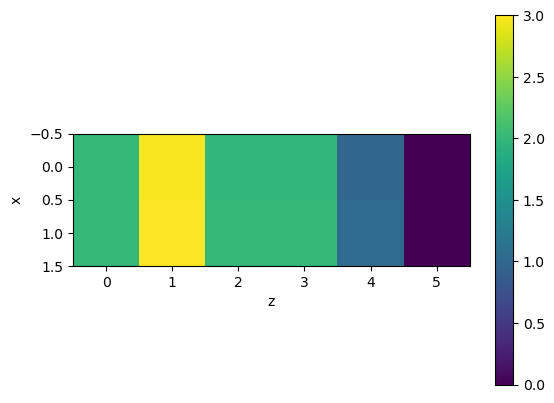

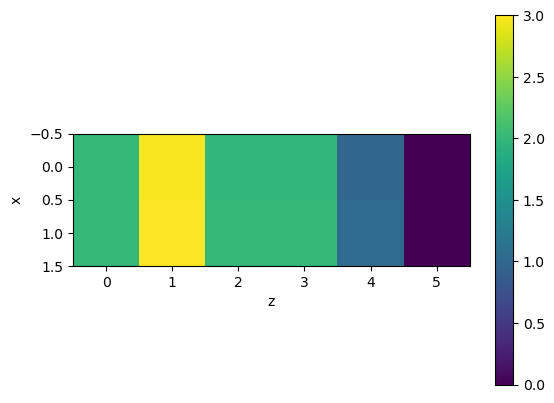

In [6]:
plt.figure()
plt.imshow(init_W_over_time[-1].sum(-1), vmin=0)
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.figure()
plt.imshow(W_over_time[-1].sum(-1), vmin=0)
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()